# 집값 예측

- Data fields
    - ID : 집을 구분하는 번호 (train set에서만 삭제)
    - zipcode : 우편번호 (삭제)
    - price : 집의 가격(Target variable)
    - date : 집을 구매한 날짜
    - bedrooms : 침실의 수
    - bathrooms : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )
    - floors : 집의 층 수
    - waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    - view : 집이 얼마나 좋아 보이는지의 정도
    - condition : 집의 전반적인 상태  
    - grade : King County grading 시스템 기준으로 매긴 집의 등급   
    - yr_built : 지어진 년도 
    - yr_renovated : 집을 재건축한 년도
    - lat : 위도
    - long : 경도
    - 아래 둘이 합치기
        - sqft_above : 지하실을 제외한 평방 피트(면적)
        - sqft_basement : 지하실의 평방 피트(면적)  
    - 거래일 14년인지 15년인지에 따라 다르게 적용
        - sqft_living : 주거 공간의 평방 피트(면적)
        - sqft_lot : 부지의 평방 피트(면적)
        - sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
        - sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

In [1]:
# machine learning : train, test set
from sklearn.model_selection import train_test_split

# machine learning : Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [2]:
#root_meam_squared_error
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [3]:
def categ_or_contin(df, criterion=10, cat_or_cont=True, print_col = True):
    '''
    df의 column을 이루고 있는 value들 종류 갯수를 파악하여 연속형 변수와 범주형 변수로 구분해주는 함수.
    cat_or_cont = True (default) : 연속형 변수 출력
    cat_or_cont = False : 범주형 변수 출력
    criterion(default = 10) : 연속과 범주형의 기준 제시.
    ex) criterion = 10 : value의 종류가 10종이하이면 범주형 변수, 넘으면 연속형 변수
    '''   
    target_skew = df
    categorical = []
    continuous = []

    for column in target_skew: 
        if len(set(target_skew[column])) > criterion: # 범주형과 연속형 변수 구분 필요함. 
            continuous.append(column)  # 연속형
        else:
            categorical.append(column) #범주형
    if print_col == True:
        print('- categorical variables : ', categorical, '\n- continuous variables : ', continuous)
    return continuous if cat_or_cont==True else categorical
# ex) categ_or_contin(house6[0],15,False)

In [32]:
def test_for_transf(df, col_str, transf_ls):
    '''
    Continous variable의 적절한 전처리를 위하여 '입력된 수식들로 변환된 column' vs 'frequency'의 그래프를 출력하는 함수.
    (사용시 추천예시) : 이렇게 같은 cell에 variable들을 정의하고, 함수안에선 수식만 바꾸면 더 편하다.
    df = house7[0]; col_str = 'bathrooms'; x = df[col_str];
    test_for_transf(df, col_str ,[x, np.log(x), (x-x.min())**(2/3)] )

    df : 해당 데이터프레임 입력
    col_str : df에서 확인해보고 싶은 column 하나를 string으로 입력 ex) 'price'
    transf_ls : 'del x'를 선행한 후 테스트 해보고 싶은 transfromation 수식을 target에대한 함수로 만들어서 list형태로 입력 
        ex) [(x-x.min())^2, np.log(x)]
    '''
    from scipy.stats import norm
    target_col = col_str
    target = df[target_col]
    target_transf = transf_ls # test해보고 싶은 transf 수식들 다 list 안에 넣기
    for i in range(len(target_transf)):
        # let's plot a histogram with the fitted parameters used by the function
        sns.distplot(target_transf[i] , fit=norm);
        # get mean and standard deviation
        (mu, sigma) = norm.fit(target_transf[i])
        # add legends to the plot
        plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                    loc='best')
        plt.ylabel('Frequency')
#        plt.title(target_col)
        plt.show()

In [100]:
def check_skew(df, column_list_=None, skewness=1.5, criterion_of_cont_var=15, print_col_=True):
    '''
    df의 column인 column_list 중 왜도(skewness)가 1.5(default)보다 큰 column을 출력하는 함수.
    column_list(default=df.column, True = 연속형, False = 범주형, list = 그 list) 
            : df의 column들 중 왜도를 확인해볼 column list 입력. 
    skewness(default=1.5) : 기준 왜도값 입력.
    print_col_(default=True) : True이면 연속형 변수와 범주형 변수들을 리스트 형태로 보여줌
    '''
    from scipy.stats import skew
    target_skew = df
    if column_list_ == None: #구분할 행을 입력하지 않으면 df의 전체 행을 입력해준다.
        column_list=list(df.columns)
    elif column_list_ == True:
        column_list=categ_or_contin(target_skew,criterion_of_cont_var,True, print_col=print_col_)
    elif column_list_ == False:
        column_list=categ_or_contin(target_skew,criterion_of_cont_var,False, print_col=print_col_)
    else :
        column_list=column_list_
    # df.skew(): 열별 왜도
    biased_condition = abs(target_skew[column_list].skew()) > skewness # biased_condition : 1.5보다 크면 치우쳤다고 간주함
    # biased_variables: 왜도의 절대 값이 1.5보다 큰 변수
    biased_variables = target_skew[column_list].columns[biased_condition] 
    print('Columns {}에서 \n skewness가 {}보다 높은 columns은 {}이다.\n'.format(column_list, skewness, list(biased_variables)))
    
    

In [6]:
def Remove_outliers(IQR_target_df, criterion_of_cont_var=15, criterion_Q1=0.25, criterion_Q3=0.75):
    '''
    IQR rule에 따라 연속형 변수의 이상치를 제거해주는 함수.
    IQR rule : Q3-1.5*IQR보다 크거나 Q1-1.5*IQR보다 작으면 이상치라고 판단. 삭제
    IQR_target_df : 타겟이 될 데이터 프레임
    criterion_of_cont_var (default=15) : 연속형 변수의 기준.
    ex) Remove_outliers(house4_1[0], 20)
    '''
    IQR_target = IQR_target_df #house4_1[0]
    continuous_IQR = categ_or_contin(IQR_target,criterion_of_cont_var,print_col=False)

    len_before = len(IQR_target)
    Q1 = IQR_target[continuous_IQR].quantile(criterion_Q1)
    Q3 = IQR_target[continuous_IQR].quantile(criterion_Q3)
    IQR = Q3 - Q1
    condition1 = Q1 - 1.5*IQR < IQR_target[continuous_IQR]
    condition2 = Q3 + 1.5*IQR > IQR_target[continuous_IQR]
    IQR_target[continuous_IQR] = IQR_target[continuous_IQR][condition1 & condition2]
    # IQR rule : Q3-1.5*IQR보다 크거나 Q1-1.5*IQR보다 작으면 이상치라고 판단. 삭제
    IQR_target.dropna(inplace=True)
    IQR_target.reset_index(drop=True, inplace=True)
    len_after = len(IQR_target)
    print('Outliers are completely removed. Length is redeced from {} to {}'.format(len_before, len_after))
#Remove_outliers(house4_1[0])

In [7]:
def count_category(target, criterion_of_cont_var=10, sort_category = False):
    '''
    target의 columns 중 categorical variable의 category 종류 및 각 category에 대한 샘플의 수를 count해주는 함수.
    target : 원하는 dataframe을 입력.
    criterion_of_cont_var (default=10) : categorical variable의 기준을 입력.
        ex) criterion_of_cont_var=10 : variable이 10 종 이하로 전부 분류되면 categorical variable.
    sort_category (default = False) : False면 sample수가 많은 카테고리 순으로 배열, True면 카테고리를 오름차순으로 배열
    '''
    count_target = target
    result = []
    categ_var = categ_or_contin(count_target,criterion_of_cont_var,False,False)
    
    for i in range(len(categ_var)):
        pd_count = count_target[categ_var[i]].value_counts()
        pd_count = pd_count.reset_index().rename(columns = {'index': 'category'})
        if sort_category == True:
            pd_count.sort_values(by = ['category'], ascending=sort_category, inplace=True)
            pd_count.reset_index(drop=True, inplace=True)
        result.append(pd_count)
    return pd.concat(result,axis=1)


In [75]:
def features_vs_frequency(df_target_, figsize_tuple_ = (12,10), loc_='best'):
    '''
    df_target_의 features_들의 분포를 행렬 그래프로 그리는 함수
    df_target_ : 그래프들 그려볼 data frame
    figsize_tuple_ : 전체 그래프 사이즈를 튜플로 입력
    loc_ : lengend 위치 설정
      ex) loc_ = 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 
                'center left', 'center right', 'lower center', 'upper center', 'center' 
    '''
    from scipy.stats import norm
    
    df_target = df_target_
    figsize_tuple = figsize_tuple_
    
    col = df_target.columns # df_target의 feature list
    
    # data frame의 feature의 갯수에 따라 적절한 행과 열을 결정해준다.
    length = len(col)
    row_len = int(round(length**(1/2),0))
    col_len = int(round(length/row_len,0))+1 if row_len*round(length/row_len,0) < length else \
        int(round(length/row_len,0))
    print('그래프가 {}X{}행렬로 그려집니다.'.format(row_len, col_len))
    
    # let's plot a histogram with the fitted parameters used by the function
    fig = plt.figure(figsize=figsize_tuple)
    for i in range(len(col)):
        target = df_target[col[i]]
        axi = fig.add_subplot(row_len,col_len,i+1)
        sns.distplot(target , fit=norm, ax=axi)
        plt.ylabel('Frequency')
        plt.legend([col[i]], loc=loc_)


In [143]:
def features_vs_label(df_target_, label_str , col_target=None, figsize_tuple_ = (12,10), loc_='best'):
    '''
    df_target_의 col_target vs label를 행렬 그래프로 그리는 함수
    df_target_ : 그래프들 그려볼 data frame
    label_str : df_target_의 label을 str 형태로 입력.
    col_target : label에 대한 분포를 파악하기를 원하는 features를 list형태로 입력.
    figsize_tuple_ : 전체 그래프 사이즈를 튜플로 입력
    loc_ : lengend 위치 설정
      ex) loc_ = 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 
                'center left', 'center right', 'lower center', 'upper center', 'center' 
    '''
    if col_target == None: #구분할 행을 입력하지 않으면 df의 전체 행을 입력해준다.
        col = list(df_target_.columns)
    else :
        col = col_target    
    
    df_target = df_target_
    figsize_tuple = figsize_tuple_
    
    
    # data frame의 feature의 갯수에 따라 적절한 행과 열을 결정해준다.
    length = len(col)
    row_len = int(round(length**(1/2),0))
    col_len = int(round(length/row_len,0))+1 if row_len*round(length/row_len,0) < length else \
        int(round(length/row_len,0))
    print('그래프가 {}X{}행렬로 그려집니다.'.format(row_len, col_len))

    # columns vs label
    fig = plt.figure(figsize=figsize_tuple)
    for i in range(len(col)):
        axi = fig.add_subplot(row_len,col_len,i+1)
        sns.regplot(x=col[i], y=label_str, data=df_target, ax=axi)
        plt.legend([col[i]], loc=loc_)

In [90]:
def one_feature_vs_freqency(df_target, col_name, loc_='best'):
    '''
    f_target의 feature인 col_name의 분포(frequency)를 행렬 그래프로 그리는 함수
    df_target : 그래프를 그려볼 data frame
    col_name : 그래프를 그려볼 featreu 이름 type = str
    loc_ : lengend 위치 설정
        ex) loc_ = 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 
            'center left', 'center right', 'lower center', 'upper center', 'center' 
    '''
    from scipy.stats import norm, skew

    target = df_target[col_name]
    col_target = col_name
    
    # skewness 체크
    print("Skewness: %f" % target.skew())
    
    # let's plot a histogram with the fitted parameters used by the function
    sns.distplot(target , fit=norm);
    # get mean and standard deviation
    (mu, sigma) = norm.fit(target)
    # add legends to the plot
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc=loc_)
    plt.ylabel('Frequency')
    plt.title(col_target);

In [129]:
def corr_heatmap(df_corr, sort_by_col, column_list_=None, figsize_tuple=(12, 10), ascending_=False, palette_color='purple', fmt_=".2f"):
    '''
    df_corr의 feature+label 사이의 correlation coefficient를 heatmap으로 나타내는 함수.
    df_corr : 상관계수 heatmap을 그려 볼 data frame
    sort_by_col : 상관계수를 sort_by_col 기준으로 정렬 cf) 보통 label로 설정
    fig_size (default=(12, 10)) : heatmap figure size
    ascending_ (default=False) : 상관계수 내림차순 정렬(False), 오름차순 정렬(True)
    palette_color (default='purple') : 상관계수 나타낼 색
    fmt_ (default=".2f") : 표시되는 상관계수의 자릿수. cf) ".2f": 소숫점 2자리수 float
    '''
    if column_list_ == None: #구분할 행을 입력하지 않으면 df의 전체 행을 입력해준다.
        column_list = list(df_corr.columns)
    else :
        column_list = column_list_
    
    # 상관계수 구해서 그래프 그리기.
    h_corr = df_corr[column_list].corr(method='pearson').sort_values(by=[sort_by_col], ascending = ascending_)\
                .sort_values(by=[sort_by_col], axis =1, ascending=ascending_)  
    # 상관계수 dataframe /  가격과 상관계수 큰 순으로 정렬(행과 열 모두다 정렬)
    
    #heatmap으로 그리기
    plt.figure(figsize=figsize_tuple)
    sns.heatmap(h_corr, cmap=sns.light_palette(palette_color, as_cmap=True), annot=True, fmt=fmt_)
    plt.show()

## train data, test data 불러오기

In [8]:
# train data, test data 불러오기
house_train = pd.read_csv("dataset/train.csv", engine = 'python')
house_test = pd.read_csv("dataset/test.csv", engine = 'python')
house = [house_train.copy(), house_test.copy()]
#house_train = house[0]
#house_test = house[1]

In [9]:
# 라벨에대한 정규화는 하지 않는게 맞는듯
#h_max = house_train['price'].max() #train set에서 제일 비싼애들 기준으로 정규화

In [10]:
for i in range(len(house)):
    # house의 id 드랍
    house[i].drop(columns= ['id'], inplace = True)
    # date(구매시기) 데이터 줄여주기 ex) 20141013T000000 -> 20141013 ->2014.1013  
    #(구매와 건축 시기 차이 구할 때 유용)
    house[i]['date'] = [round(int(house[i]['date'].iloc[j][:8])/10000, 4) \
                        for j in range(len(house[i]))]
    # price 정규화 0 < price < 1
    house[0]['price'] = house[0]['price'] #test set에는 price없으니 train set만 정규화

#NAN 존재여부 테스트
for i in range(len(house)):
    test = house[i].isnull().sum().sum()  
    if test == 0:
        print('house[{}] : NAN 데이터 없음.'.format(i))
    else:
        print('house[{}] : NAN 데이터가 {}개 있음.'.format(i, test))
# Nan 없음.

house[0] : NAN 데이터 없음.
house[1] : NAN 데이터 없음.


### #. zipcode : 삭제
- zipcode는 위치와 상관이 없다.
- 같은 zipcode를 가지는 집들 중 (위도, 경도)를 구글 지도에 찍어보면 서로 완전 다른 지역을 나타내고 있다.
- 따라서 zipcode는 무의미한 정보이다.
- 완료 데이터 : house1

In [11]:
# zipcode와 (위도, 경도) 정보 조사
for i in range(len(house)):
    h_zip = house[i][['zipcode', 'lat', 'long']].sort_values(by = ['zipcode'])\
    .reset_index(drop=True).head()
    print(h_zip)

   zipcode      lat     long
0    98001  47.3530 -122.294
1    98001  47.2619 -122.271
2    98001  47.3318 -122.277
3    98001  47.3359 -122.257
4    98001  47.3524 -122.285
   zipcode      lat     long
0    98001  47.3398 -122.286
1    98001  47.2849 -122.251
2    98001  47.2871 -122.287
3    98001  47.3427 -122.274
4    98001  47.3260 -122.273


In [12]:
#zipcode 삭제
house1 = []
for i in range(len(house)):
    house1.append(house[i].drop(columns=['zipcode']))
#house_test.drop(columns=['zipcode'], inplace=True)

### #. sqft_lot, sqft_living 전처리
- 거래일이 14년인 것은 sqft_lot, living을 사용
- 거래일이 15년인 것은 sqft_lot15, living15로 사용
- house2

In [13]:
house1[0].head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,2014.1013,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650
1,2015.0225,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,2015.0218,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
3,2014.0627,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,2238,6819
4,2015.0115,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711


In [14]:
# 'sqft_lot,living15'과 'sqft_lot,living' 중 년도 구분해서 적절한 sqft 적용
house2 = []
for i in range(len(house1)):
    h_2014 = house1[i][house1[i]['date'] < 2015].drop(columns = ['sqft_living15', 'sqft_lot15'])
    h_2015 = house1[i][house1[i]['date'] >= 2015].drop(columns = ['sqft_living', 'sqft_lot'])\
        .rename(columns={'sqft_living15' : 'sqft_living', 'sqft_lot15' : 'sqft_lot'})
    house2.append(pd.concat([h_2015,h_2014],axis=0, sort=False).sort_index())

In [15]:
house2[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living,sqft_lot
0,2014.1013,221900.0,3,1.00,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1180,5650
1,2015.0225,180000.0,2,1.00,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062
2,2015.0218,510000.0,3,2.00,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503
3,2014.0627,257500.0,3,2.25,2.0,0,0,3,7,1715,0,1995,0,47.3097,-122.327,1715,6819
4,2015.0115,291850.0,3,1.50,1.0,0,0,3,7,1060,0,1963,0,47.4095,-122.315,1650,9711


### #. sqft_above + sqft_basement
- 전체 평수(sqft_total = sqft_above와 sqft_basement) 계산
- sqft_above와 sqft_basement는 삭제
- 근데 이게 sqft living보다 값이 작아서 뭐가 맞는건지 모르겠음. (추후에 지워야할수도)
- house3

In [16]:
house3 = []
for i in range(len(house2)):
    house3.append(house2[i].copy())
    house3[i]['sqft_total'] = house3[i]['sqft_above']+house3[i]['sqft_basement']
    house3[i].drop(columns = ['sqft_above', 'sqft_basement'], inplace = True)

In [17]:
house3[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,lat,long,sqft_living,sqft_lot,sqft_total
0,2014.1013,221900.0,3,1.00,1.0,0,0,3,7,1955,0,47.5112,-122.257,1180,5650,1180
1,2015.0225,180000.0,2,1.00,1.0,0,0,3,6,1933,0,47.7379,-122.233,2720,8062,770
2,2015.0218,510000.0,3,2.00,1.0,0,0,3,8,1987,0,47.6168,-122.045,1800,7503,1680
3,2014.0627,257500.0,3,2.25,2.0,0,0,3,7,1995,0,47.3097,-122.327,1715,6819,1715
4,2015.0115,291850.0,3,1.50,1.0,0,0,3,7,1963,0,47.4095,-122.315,1650,9711,1060


### #. yr_built 처리 : 거래당시 집의 연차 계산 + #. yr_renovated 처리 : 재건축 유무로 변경
- 거래당시 지어진지 몇년되었는지 계산.
- round(date,0) - yr_built
- 재건축 유 = 1
- 재건축 무 = 0
- 두가지 년도 관련 전처리 후 데이터 : house4

In [18]:
# 거래당시 집의 연차 계산
house4 = []
for i in range(len(house3)):
    house4.append(house3[i].copy())
    house4[i]['yr_built'] = round(house4[i]['date'], 0) - house4[i]['yr_built']

In [19]:
for i in range(len(house4)):
    house4[i]['yr_renovated'][house4[i]['yr_renovated'] == 0] = 0
    house4[i]['yr_renovated'][house4[i]['yr_renovated'] != 0] = 1

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
house4[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,lat,long,sqft_living,sqft_lot,sqft_total
0,2014.1013,221900.0,3,1.00,1.0,0,0,3,7,59.0,0,47.5112,-122.257,1180,5650,1180
1,2015.0225,180000.0,2,1.00,1.0,0,0,3,6,82.0,0,47.7379,-122.233,2720,8062,770
2,2015.0218,510000.0,3,2.00,1.0,0,0,3,8,28.0,0,47.6168,-122.045,1800,7503,1680
3,2014.0627,257500.0,3,2.25,2.0,0,0,3,7,19.0,0,47.3097,-122.327,1715,6819,1715
4,2015.0115,291850.0,3,1.50,1.0,0,0,3,7,52.0,0,47.4095,-122.315,1650,9711,1060


### !!!! 이상치. 거래일(date)보다 건축일(yr_built)가 더 나중임. 지어지기전에 거래??

In [21]:
idx_built_outliers = house4[0]['yr_built'][house4[0]['yr_built']==-1].index
idx_built_outliers2 = house4[1]['yr_built'][house4[0]['yr_built']==-1].index
idx_built_outliers2

Int64Index([1264, 1920, 5303, 5654], dtype='int64')

In [22]:
house3[0][['date', 'yr_built','yr_renovated']].iloc[idx_built_outliers]
house3[1][['date', 'yr_built','yr_renovated']].iloc[idx_built_outliers2]
# 토지 구매후 짓기 시작했나? 음...

,date,yr_built,yr_renovated
1264,2014.0730,2004,0
1920,2015.0102,2001,0
5303,2015.0430,2002,0
5654,2015.0105,1963,0


### #. date 전처리 
- 지금의 date 데이터는 2014.1230과 2015.0101사이에 갭이 있다
- date 최솟값 (2014.0502)을 시작으로 월만 더하기 형태로 간다.
- ex) 2014.0502 -> 2014.0502-2014 = 0.0502 -> 5 -> 5 - 4 = 1
- ex) 2015.0102 -> 2015.0102-2015+0.12(2014년의 12달) = 0.1302 -> 13 -> 13-4 = 9
- ..
- **(yr_buit 뒤집기 이하 삭제): 비슷한 집일때 오래된 집일 수록 좀더 비싸다**
- yr_built는 지어진지 오래될 수록 큰 값을 가진다.
- 하지만 오래될수록 집값은 떨어진다. 따라서 최근에 지어질 수록 큰값 부여하기. 
- yr_built를 최댓값 기준으로 빼기. = yr_built_inv

In [27]:
house5 = []
# date년도 순으로 categorical variable로 변환 2014.05.. -> 1
# 데이터들 중 처음 거래가 이루어진 날짜
# h_date_min = house4[0]['date'].min()
for i in range(len(house4)):
    house5.append(house4[i].copy())
#     ex) 2014.0502 -> 2014.0502-2014 = 0.0502 -> 5 -> 5 - 4 = 1
#     ex) 2015.0102 -> 2015.0102-2015+0.12(2014년의 12달) = 0.1302 -> 13 -> 13-4 = 9
    #2014년 건에 대한 연산
    house5[i]['date'][house5[i]['date']<2015] \
            = round((house5[i]['date'][house5[i]['date']<2015]-2014)*100,0) - 4
    #2015년 건에 대한 연산
    house5[i]['date'][house5[i]['date']>2015] \
            = round((house5[i]['date'][house5[i]['date']>2015]-2015+0.12)*100,0) - 4


# # 거래일로부터 지어진 기간의 최댓값
# h_built_max = house4[0]['yr_built'].max()    
# for i in range(len(house5)):
#     # yr_built를 최댓값 기준으로 빼기 
#     # ex) 10.0 -> 115.0(max) - 10.0 = 105.0
#     # 즉, 최근에 지어질 수록 큰값 부여.
#     house5[i]['yr_built_inv'] = h_built_max - house5[i]['yr_built']
#     house5[i].drop(columns = ['yr_built'], inplace=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [28]:
house5[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,lat,long,sqft_living,sqft_lot,sqft_total
0,6.0,221900.0,3,1.00,1.0,0,0,3,7,59.0,0,47.5112,-122.257,1180,5650,1180
1,10.0,180000.0,2,1.00,1.0,0,0,3,6,82.0,0,47.7379,-122.233,2720,8062,770
2,10.0,510000.0,3,2.00,1.0,0,0,3,8,28.0,0,47.6168,-122.045,1800,7503,1680
3,2.0,257500.0,3,2.25,2.0,0,0,3,7,19.0,0,47.3097,-122.327,1715,6819,1715
4,9.0,291850.0,3,1.50,1.0,0,0,3,7,52.0,0,47.4095,-122.315,1650,9711,1060


## #. Features의 치우침 해결

### Categorical var.의 변수 치우침 해결

In [29]:
# catgorical variable들의 분포 파악
count_category(house[0],15, True)

,category,bedrooms,category,floors,category,waterfront,category,view,category,condition,category,grade
0,0.0,4.0,1.0,7361.0,0.0,14928.0,0.0,13548.0,1.0,21.0,1,1
1,1.0,133.0,1.5,1330.0,1.0,107.0,1.0,241.0,2.0,110.0,3,2
2,2.0,1931.0,2.0,5810.0,NaN,NaN,2.0,665.0,3.0,9793.0,4,23
3,3.0,6835.0,2.5,113.0,NaN,NaN,3.0,373.0,4.0,3956.0,5,174
4,4.0,4797.0,3.0,417.0,NaN,NaN,4.0,208.0,5.0,1155.0,6,1406
5,5.0,1108.0,3.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,7,6228
6,6.0,188.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,4207
7,7.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1855
8,8.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,781
9,9.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,288


In [35]:
# catgorical variable들의 분포 파악
count_category(house[1],15, True)

,category,bedrooms,category,floors,category,waterfront,category,view,category,condition,category,grade
0,0,9,1.0,3251.0,0.0,6412.0,0.0,5837.0,1.0,8.0,3.0,1.0
1,1,62,1.5,565.0,1.0,56.0,1.0,91.0,2.0,57.0,4.0,6.0
2,2,815,2.0,2406.0,NaN,NaN,2.0,297.0,3.0,4168.0,5.0,62.0
3,3,2929,2.5,48.0,NaN,NaN,3.0,134.0,4.0,1701.0,6.0,611.0
4,4,2063,3.0,194.0,NaN,NaN,4.0,109.0,5.0,534.0,7.0,2701.0
5,5,484,3.5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,1843.0
6,6,83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,754.0
7,7,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,350.0
8,8,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,108.0
9,9,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,28.0


# To do!
- grade 1,3 합치기
- condition 1,2합치기
- floors : 3.0, 3.5합치기
- bedrooms : 8이상은 다 합치기(test set에는 8,9,10,11,33이 있음)

# 범주형 변수 전처리 하기!!

### Continuous variables 분포가 치우친 것들 정규화 :  features vs Frequnecy

In [36]:
house6 = []
for i in range(len(house5)):
    house6.append(house5[i].copy())

그래프가 4X4행렬로 그려집니다.


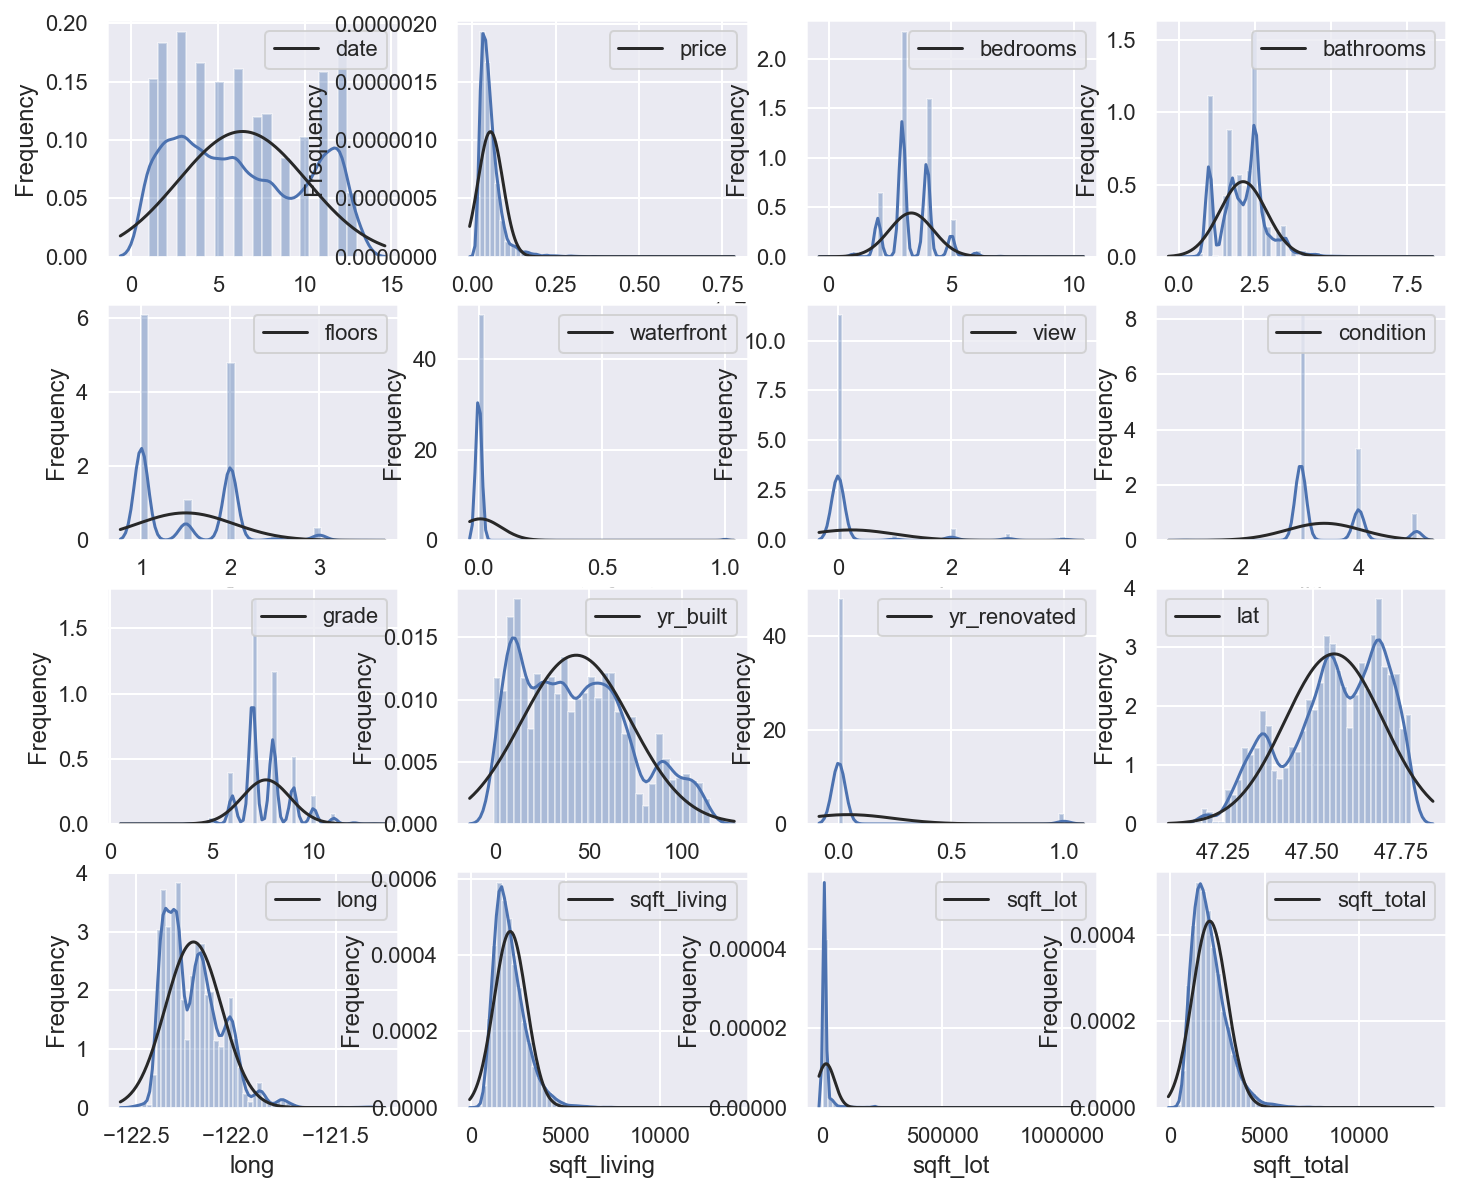

In [77]:
features_vs_frequency(house6[0])

In [78]:
# from scipy.stats import norm

# house_target = house6[0]

# # let's plot a histogram with the fitted parameters used by the function
# col = house_target.columns
# fig = plt.figure(figsize=(12, 10))
# for i in range(1,17):
#     target = house_target[col[i-1]]
#     axi = fig.add_subplot(4,4,i)
#     sns.distplot(target , fit=norm, ax=axi)
#     plt.ylabel('Frequency')
#     plt.legend([col[i]], loc='best')
# #    plt.title(col[i-1]);
# #plt.show()

### 예를 들어, price의 치우친 분포를 log scale로 바꿔서 바로 잡는 것

In [ ]:
features_vs_frequency()

Skewness: 4.290252


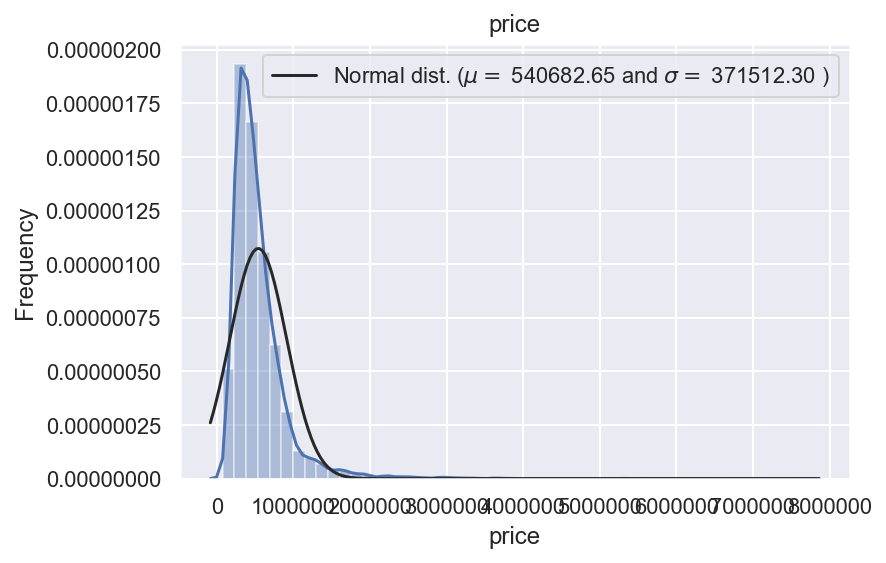

In [92]:
'''
- price의 의 분포도를 살펴보면 아래와 같이 왼쪽으로 치우쳐져있다.
- 치우친 정도가 4.29로 1.5보다 훨씬 크다. 매우 치우쳐져있음.
'''
one_feature_vs_freqency(house6[0],'price')

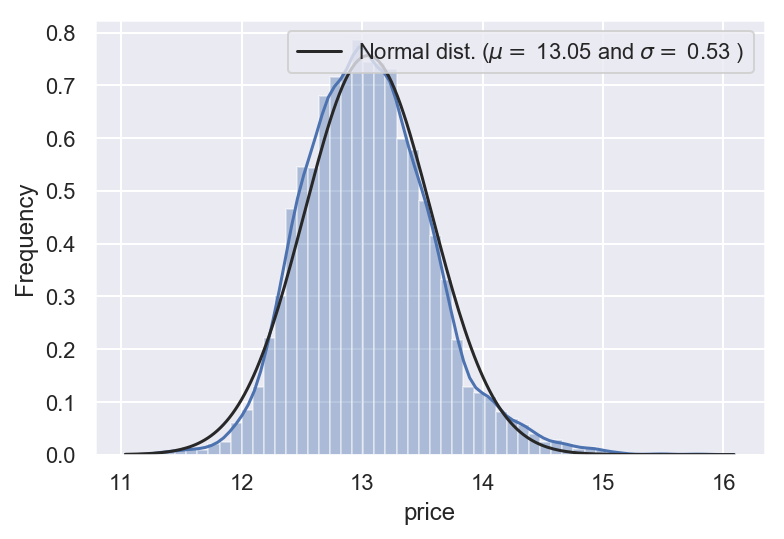

In [94]:
'''
아래와 같이 log로 변환하여 분포를 정규분포화되는 것을 확인한다.
'''
df = house6[0]; col_str = 'price'; x = df[col_str];
test_for_transf(df, col_str ,[np.log(x)] )#np.log(x+1), x, (x-x.min())**(2/3)

In [96]:
'''
이제 'price' 열의 log 값을 변환해준다.
이 경우 house6[1]은 price정보가 없기 때문에 house6[0]만 변환해준다.
'''
house6[0]['price'] = np.log(house6[0]['price']) 

In [95]:
# '''
# 아래와 같이 log로 변환하여 분포를 정규분포화되는 것을 확인한다.
# '''
# #applying log transformation
# target = np.log(target)

# # let's plot a histogram with the fitted parameters used by the function
# sns.distplot(target , fit=norm);
# (mu, sigma) = norm.fit(target)
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.title('Price (Log)');

In [91]:
# from scipy.stats import skew

# target = house6[0]['price']
# col_target = 'price'

# # skewness 체크
# print("Skewness: %f" % target.skew())

# # let's plot a histogram with the fitted parameters used by the function
# sns.distplot(target , fit=norm);
# # get mean and standard deviation
# (mu, sigma) = norm.fit(target)
# # add legends to the plot
# plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
#             loc='best')
# plt.ylabel('Frequency')
# plt.title(col_target);

### skewness를 기준으로 치우침있는 연속형 features 확인

In [104]:
check_skew(house6[0],column_list_=True, print_col_=False)

Columns ['price', 'bathrooms', 'yr_built', 'lat', 'long', 'sqft_living', 'sqft_lot', 'sqft_total']에서 
 skewness가 1.5보다 높은 columns은 ['sqft_living', 'sqft_lot']이다.



In [75]:
# min_max_target = house7

# from sklearn import preprocessing 
# min_max_scaler = preprocessing.MinMaxScaler()

# test set에 변수치우침을 train set기준으로 한다고 일단 가정.
# min_max_target[0][biased_variables] = min_max_scaler.fit_transform(np.log(min_max_target[0][biased_variables]))
# min_max_target[1][biased_variables] = min_max_scaler.transform(np.log(min_max_target[1][biased_variables]))
# #test set에는 train set에서 저장된 min_max_scaler를 가져와서 trasform만 해준다.
# # (min_max_target[0][biased_variables] - min_max_target[0][biased_variables].min())**2  
# # : 경우에 따라 log (skew > 1.5), exp(x-x.min) (skew < -1.5) 로 해도 되나? 테스트해보기



### 나머지 치우쳐져있는 변수들의 분포 바로잡기

In [105]:
check_skew(house6[0],column_list_ = True, skewness = 0.1, print_col_=False)

Columns ['price', 'bathrooms', 'yr_built', 'lat', 'long', 'sqft_living', 'sqft_lot', 'sqft_total']에서 
 skewness가 0.1보다 높은 columns은 ['price', 'bathrooms', 'yr_built', 'lat', 'long', 'sqft_living', 'sqft_lot', 'sqft_total']이다.



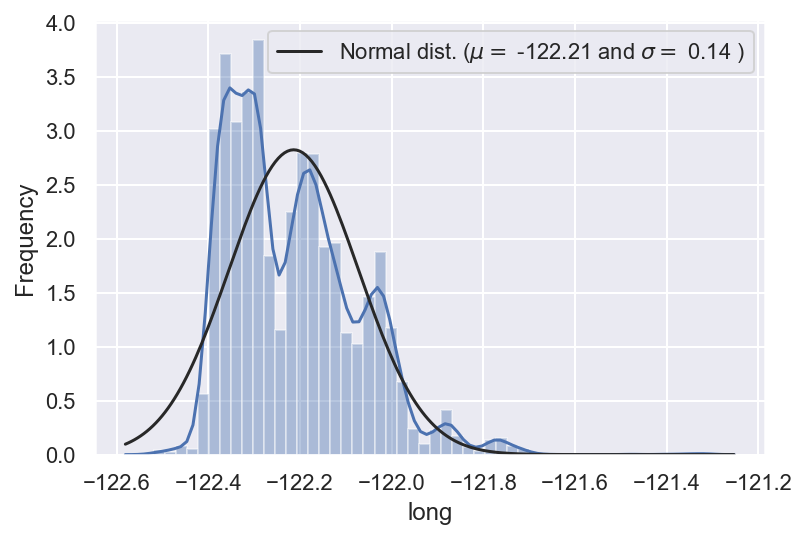

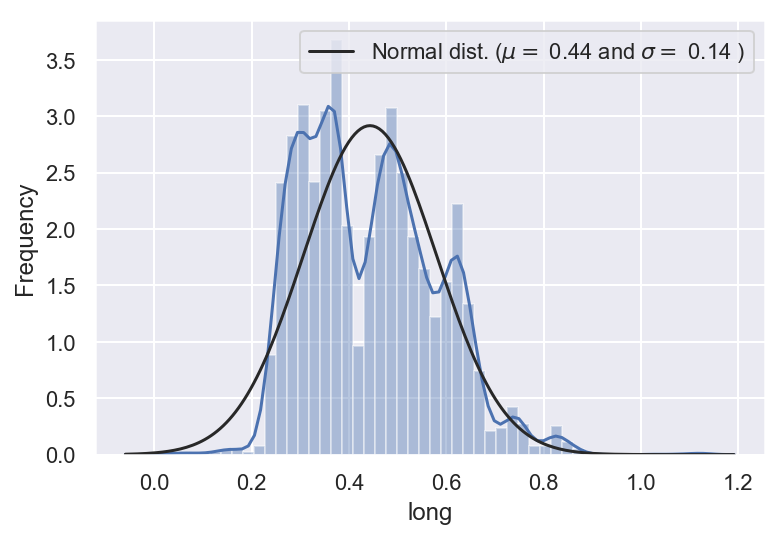

In [106]:
df = house6[0]
col_str = 'long'
######
x = df[col_str]
test_for_transf(df, col_str ,[x, (x-x.min())**(2/3)] )#np.log(x+1)

In [107]:
house7 = []
for i in range(len(house6)):
    house7.append(house6[i].copy())

In [108]:
convert_target = house7  # train + test set인 list입력
original_date = house6[0] # train set의 min, max의 기준이 될 data set

# rescaling
h_long_max = original_date['long'].max()
h_long_min = original_date['long'].min()
h_lat_min = original_date['lat'].min()
h_built_min = original_date['yr_built'].min()

for i in range(len(house6)):
    convert_target[i]['sqft_living'] = np.log(convert_target[i]['sqft_living'])
    convert_target[i]['sqft_total'] = np.log(convert_target[i]['sqft_total'])
    convert_target[i]['sqft_lot'] = np.log(convert_target[i]['sqft_lot'])
    convert_target[i]['long'] = (convert_target[i]['long'] - h_long_min)**(2/3)
    convert_target[i]['lat'] = (convert_target[i]['lat'] - h_lat_min)**2
    convert_target[i]['yr_built'] = (convert_target[i]['yr_built']-h_built_min)**(2/3)
#    convert_target[i]['bathrooms'] = np.log(1 + convert_target[i]['bathrooms'])

### !!!이상치 제거!! (제거 안하는게 더 정확도 높아서 일단 스킵)

In [109]:
house7_1 = []
for i in range(len(house7)):
    house7_1.append(house7[i].copy())

그래프가 4X4행렬로 그려집니다.


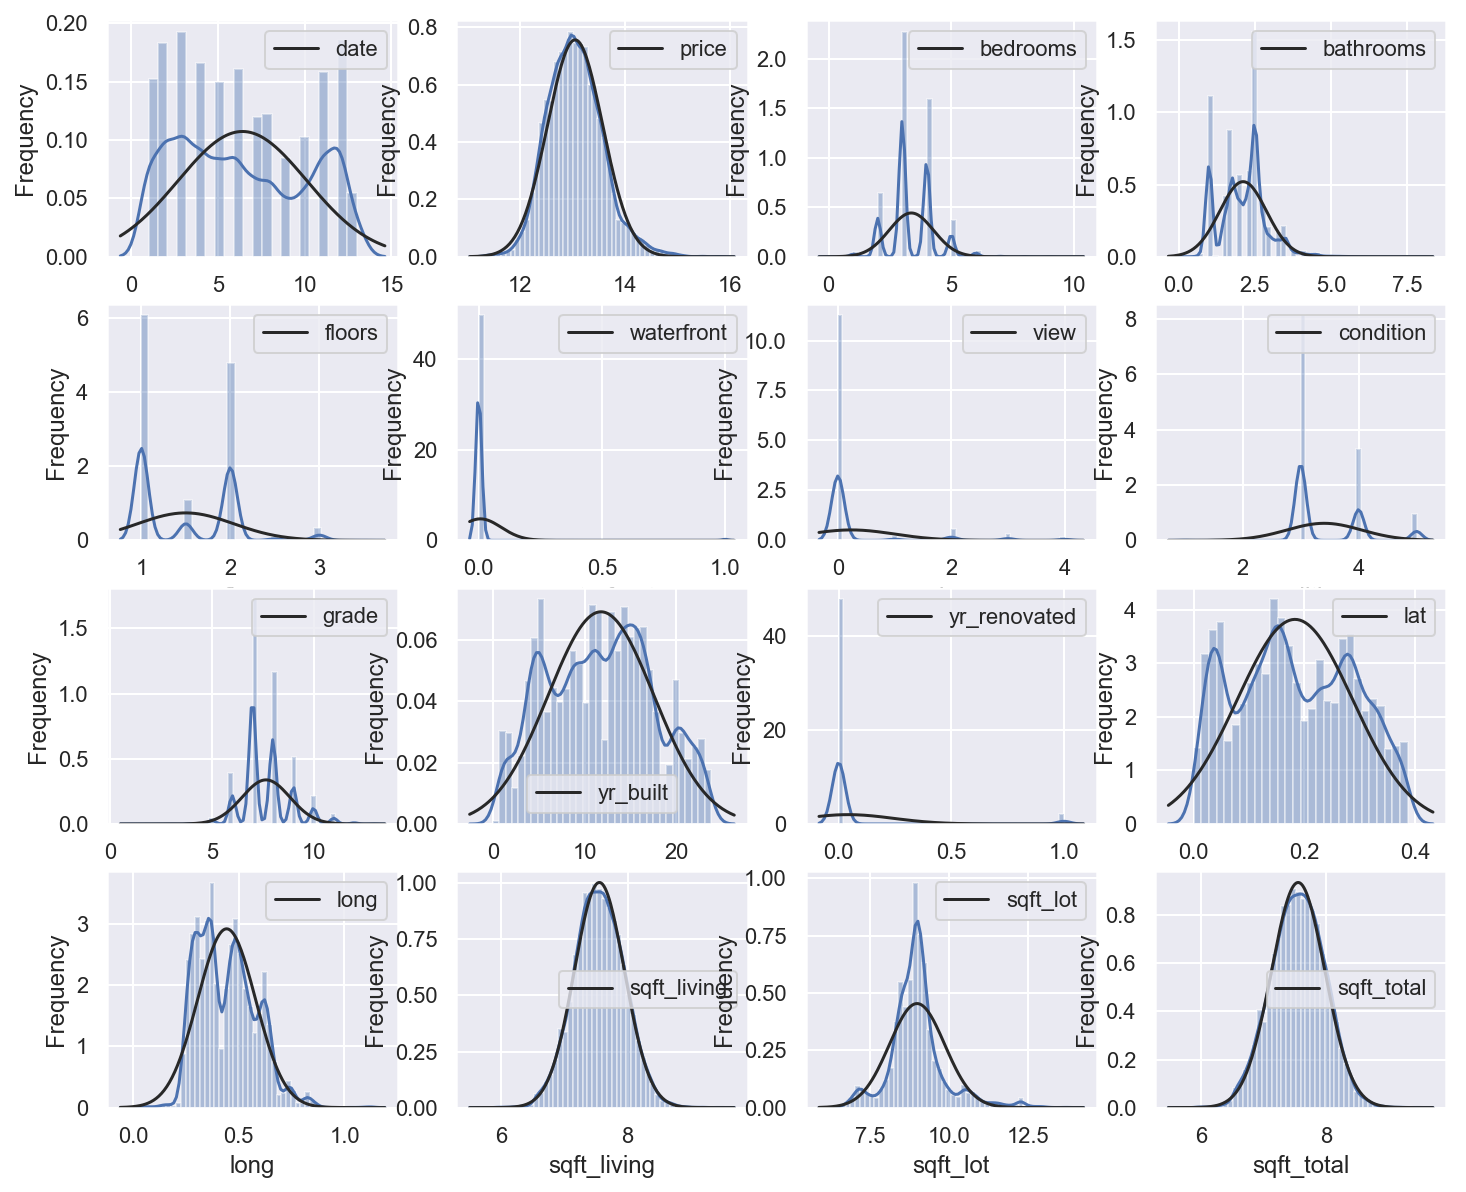

In [110]:
features_vs_frequency(house7_1[0])

In [111]:
Remove_outliers(house7_1[0], criterion_Q1=0.15, criterion_Q3=0.85)

Outliers are completely removed. Length is redeced from 15035 to 14685


그래프가 4X4행렬로 그려집니다.


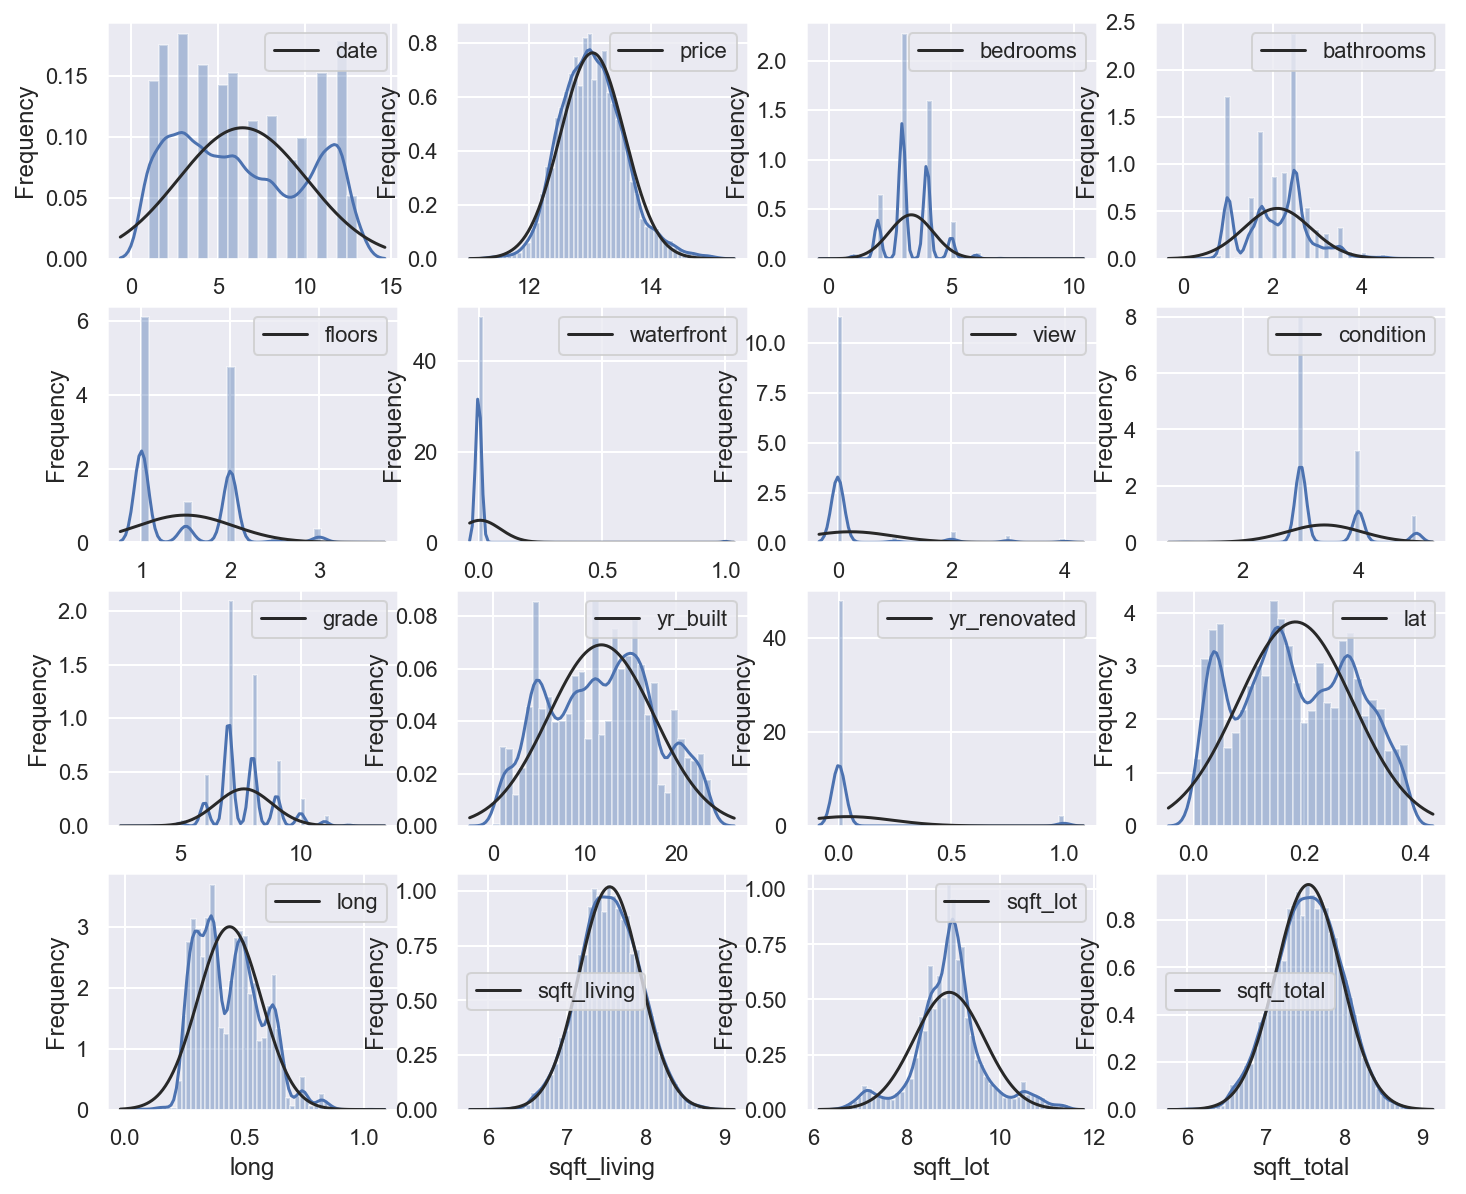

In [112]:
features_vs_frequency(house7_1[0])

- 이상치 제거했는 데 뭐가 좋은게 없는것 같아 그래서 일단 스킵

## #. Features vs price 상관계수 

그래프가 4X4행렬로 그려집니다.


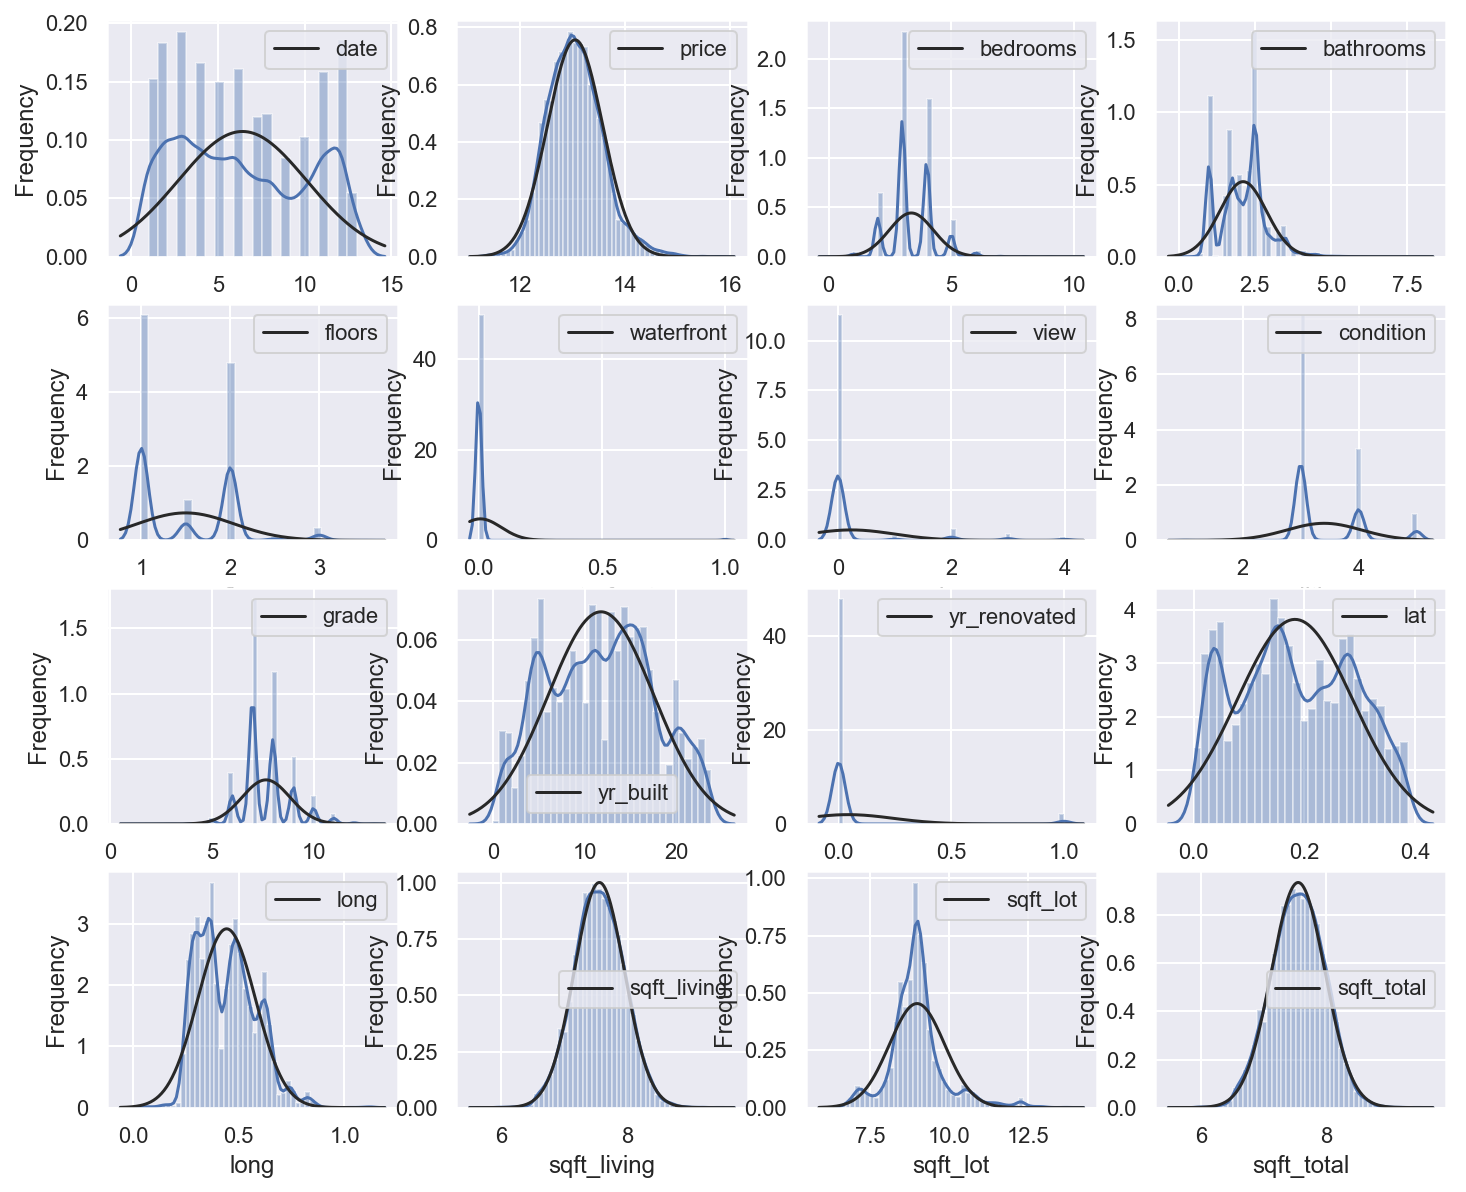

In [113]:
# rescale 처리 후 전체 분포도 
features_vs_frequency(house7[0])

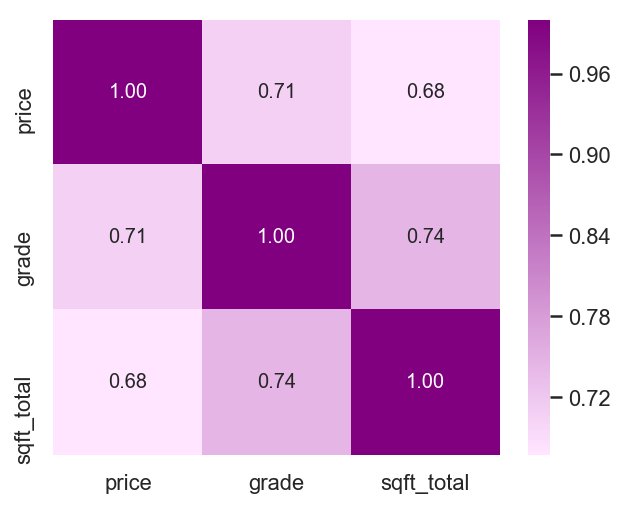

In [134]:
corr_heatmap(house7[0],'price',['price', 'grade', 'sqft_total'],figsize_tuple=(5,4))

그래프가 4X4행렬로 그려집니다.


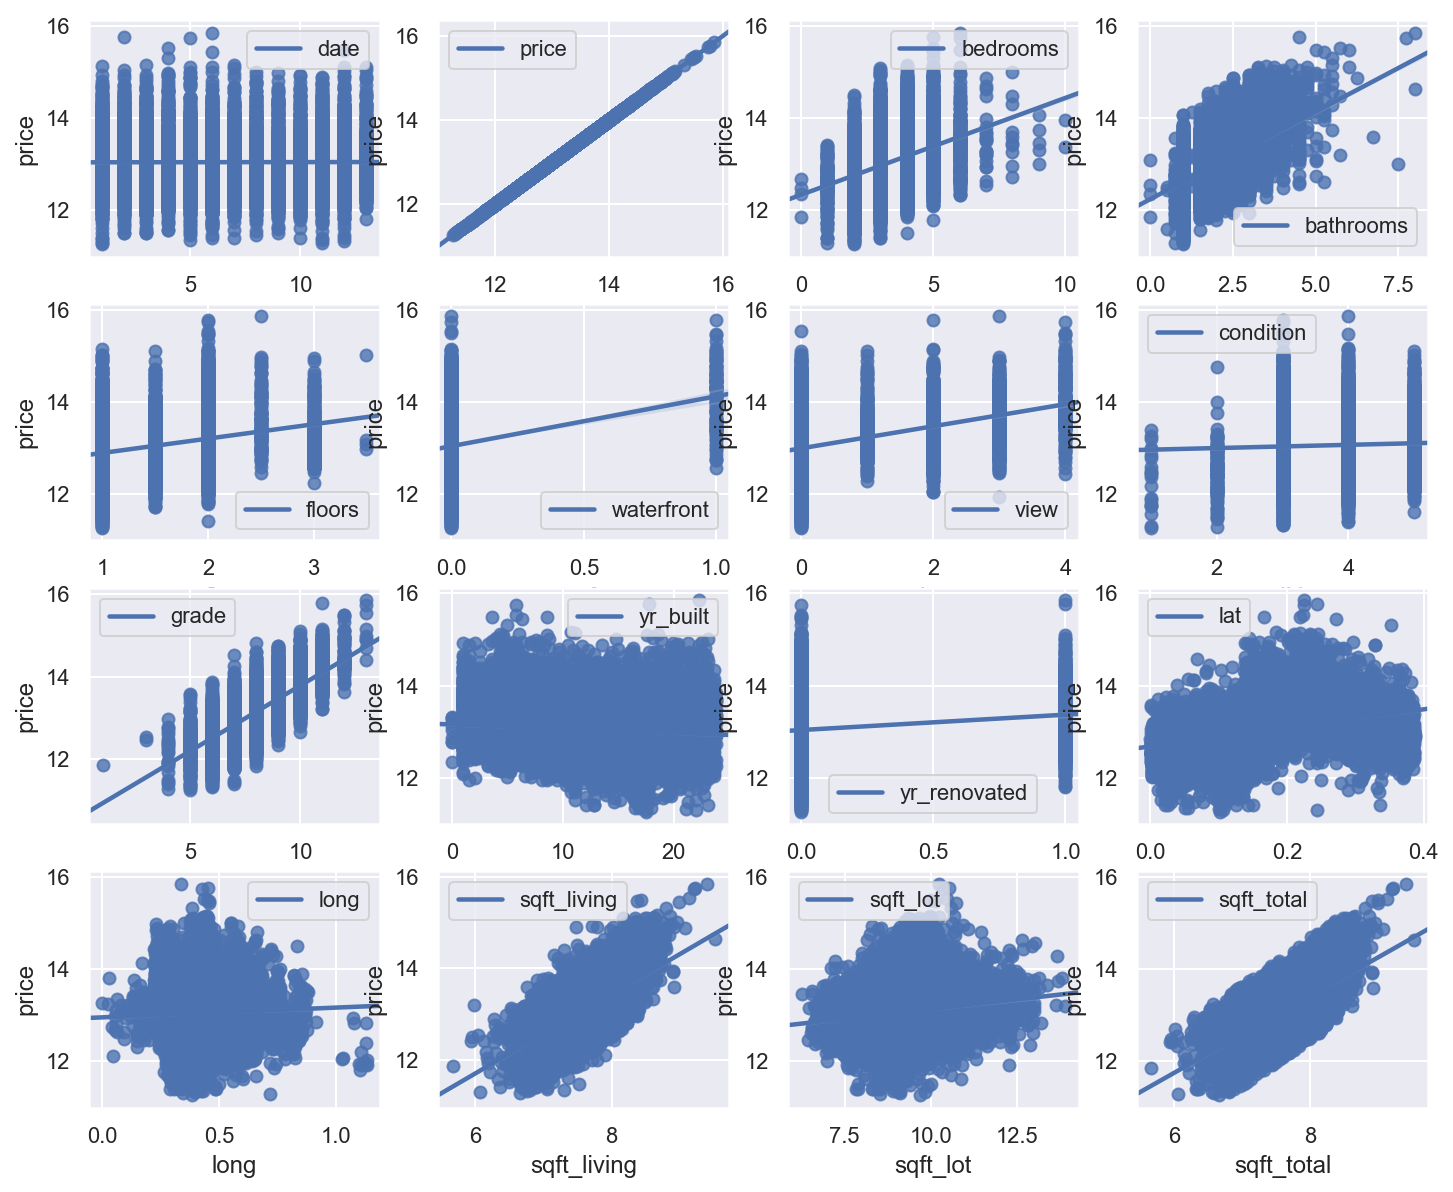

In [147]:
features_vs_label(house7[0],'price')

In [130]:
# house_corr = house7[0] # 상관계수 heatmap을 그려 볼 data frame
# sort_by_col = 'price' #상관계수를 sort_by_col 기준으로 정렬 cf) 보통 label로 설정

# fig_size = (12, 10) # heatmap figure size
# ascending_ = False  # 상관계수 내림차순 정렬(False), 오름차순 정렬(True)
# palette_color = 'purple' # 상관계수 나타낼 색
# fmt_ = ".2f" #상관계수 자릿수. ".2f": 소숫점 2자리수 float

# # 상관계수 구해서 그래프 그리기.
# h_corr = house_corr.corr(method='pearson').sort_values(by=[sort_by_col], ascending = ascending_)\
#             .sort_values(by=[sort_by_col], axis =1, ascending=ascending_)  
# # 상관계수 dataframe /  가격과 상관계수 큰 순으로 정렬(행과 열 모두다 정렬)

# #heatmap으로 그리기
# plt.figure(figsize=fig_size)
# sns.heatmap(h_corr, cmap=sns.light_palette(palette_color, as_cmap=True), annot=True, fmt=fmt_)
# plt.show()

In [146]:
# house_target = house7[0]

# # columns vs price
# col = house_target.columns
# fig = plt.figure(figsize=(12, 10))
# for i in range(1,17):
#     axi = fig.add_subplot(4,4,i)
#     sns.regplot(x=col[i-1], y="price", data=house_target, ax=axi)
#     plt.legend([col[i-1]], loc='best')
# #    plt.xlabel(col[i-1])
# #    plt.title(col[i-1]);

### #. price와 yr_built, yr_renovated의 관계
- 미국인들은 완전 새집 보다 적당히 antique한 집을 선호할 수 있다는 의견을 받음
- 모든 집들을 연식에 따른 분포를 보면 당연히 스펙트럼이 고르게 퍼져있을 것임.(이미 앞에서 상관관계가 0.1인 점에서 알 수 있음)
- 따라서 비슷한 레벨의 집들을 두고 연식에 따른 가격분포를 살펴보자.
- 상관관계 1,2위 변수(grade, sqft_total)를 통제해서 비슷한 레벨로 맞추어줄것임.

**1. 비슷한 sqft_total의 집들을 대상으로 연식에 따른 가격 분포 조사**
- sqft_total이 5.66~9.51까지 있었음.
- 전부 소숫점 첫째자리에서 반올림해서 비슷한 부지 넓이 가지는 집끼리 categorizing함
- 그리고 주어진 category에서 연식 대비 집값 조사

In [234]:
house7[0]['sqft_total'].describe()

count    15035.000000
mean         7.551787
std          0.425902
min          5.669881
25%          7.265430
50%          7.554859
75%          7.847763
max          9.513404
Name: sqft_total, dtype: float64

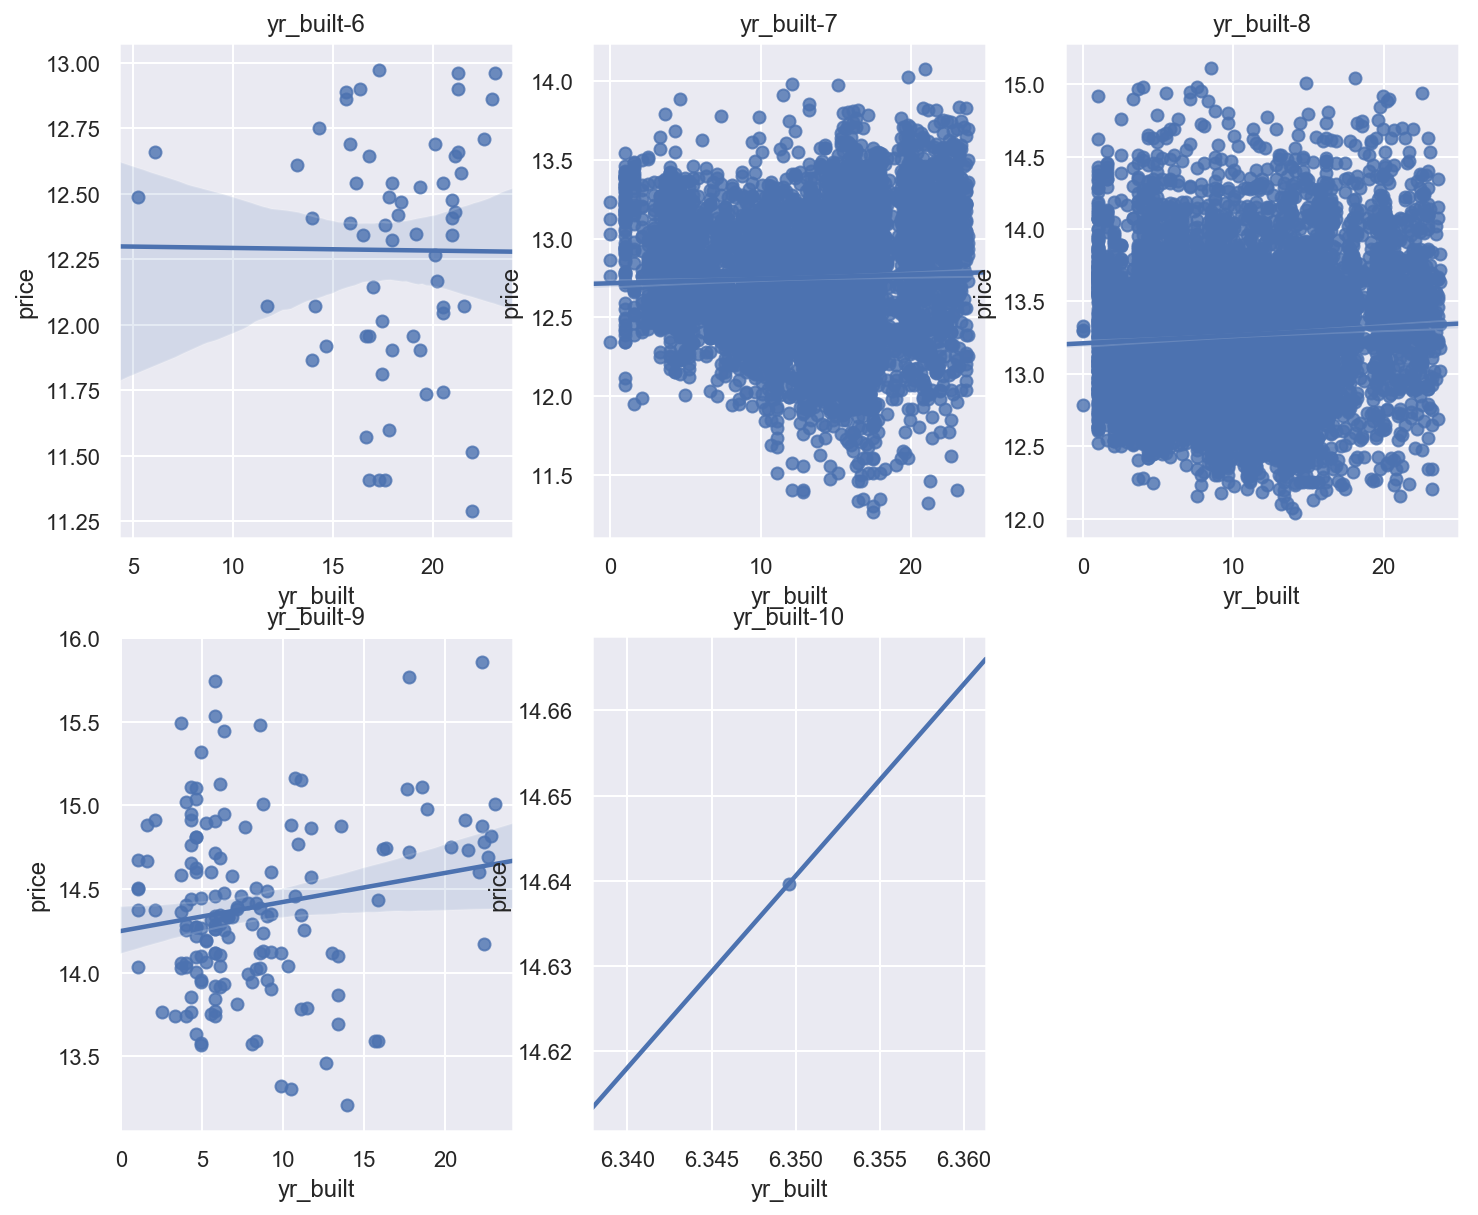

In [235]:
house_target = house7[0]

'''
총면적이 9에 있는 것들은 새집이(0에 가까울수록 새집) 비싼 경향이 있는데 아무래도 보통은 고르게 분포되어있다.
'''
fig = plt.figure(figsize=(12, 10))
for i in range(6,11):
    h_test = house_target[(round(house_target['sqft_total'],0)==i)] # & (house_target['grade'] ==8)
    axi = fig.add_subplot(2,3,i-5)
    sns.regplot(x='yr_built', y="price", data=h_test)#, ax=axi)
    plt.title('yr_built-{}'.format(i))


**2. 같은 grade의 집들을 대상으로 연식에 따른 가격 분포 조사**

In [236]:
house_target['grade'].describe()

count    15035.000000
mean         7.660725
std          1.179803
min          1.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         13.000000
Name: grade, dtype: float64

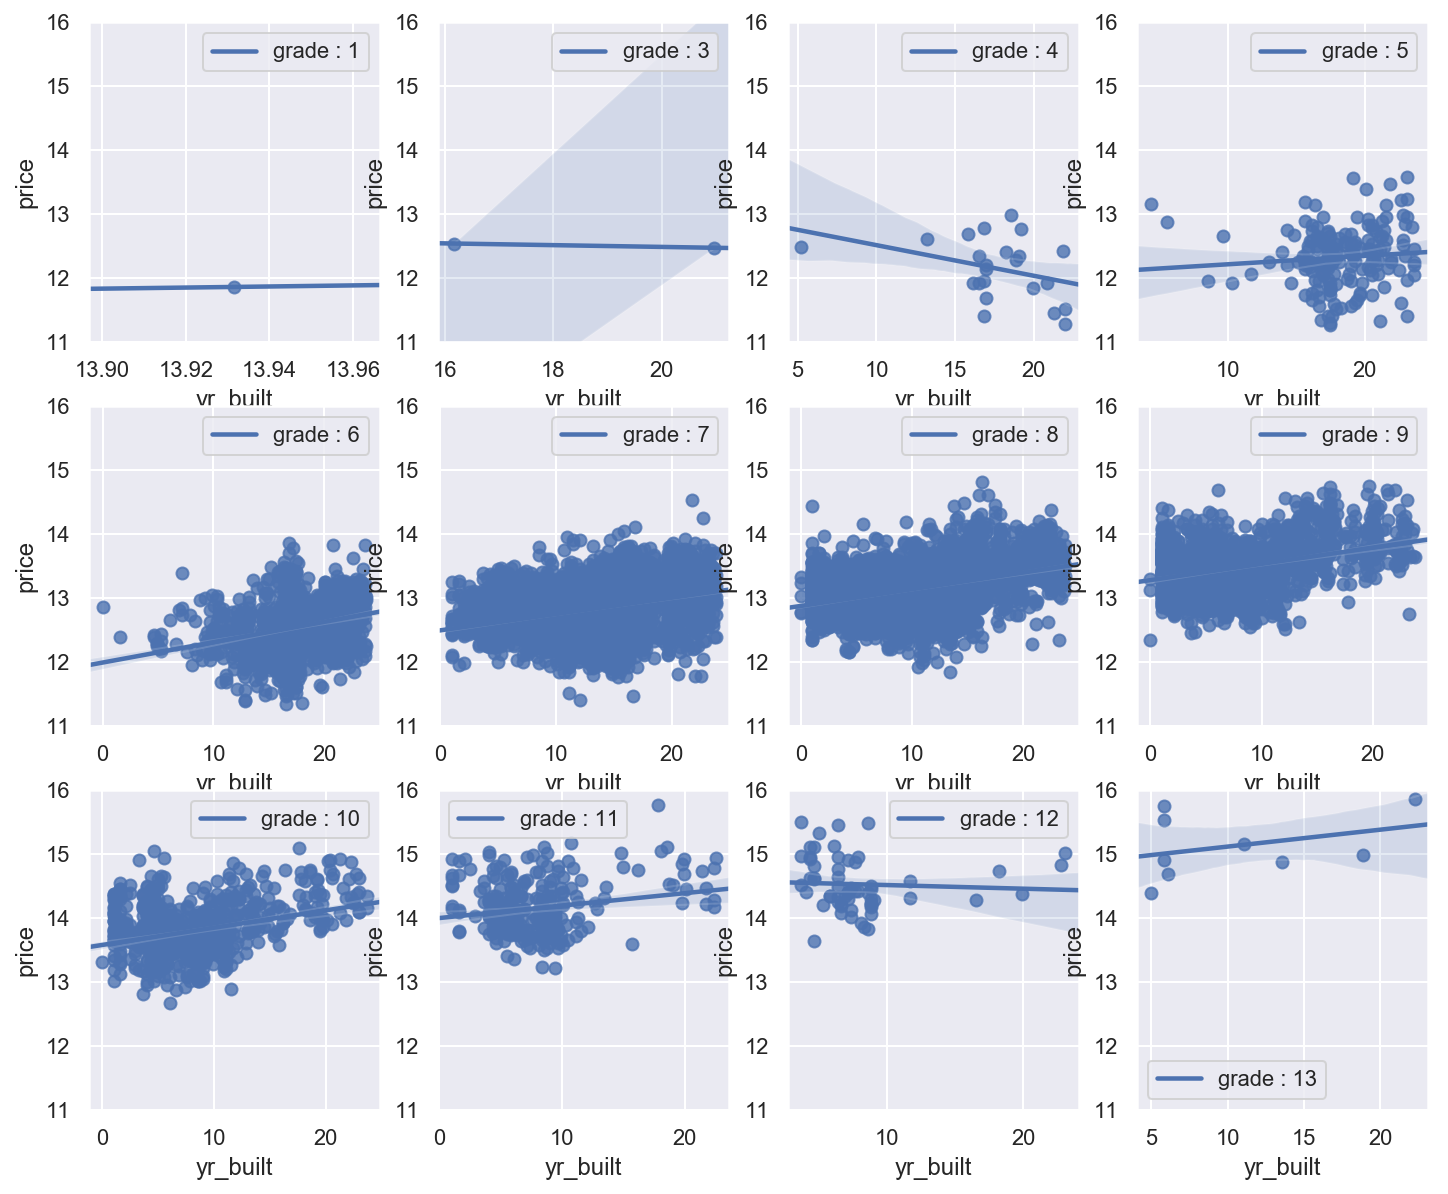

In [237]:
house_target = house7[0]

'''
1. grade가 높은 것들에는 새집(yr_built~0)이 많이 분포. grade와 yr_built가 꽤 상관관계가 있음
  1-1. 1,3,4,5은 옛날집에 너무 편중되어있음.
  1-2. 11,12,13은 새집에 너무 편중되어있음.
2. 그래도 나름 고른 분포를 보이는 6~10 그리고 11가지도 오래된 집이 좀더 비싼 경향이 있음
'''
j=0
fig = plt.figure(figsize=(12, 10))
for i in [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
    j+=1
    h_test = house_target[(house_target['grade']==i)]
    axi = fig.add_subplot(3,4,j)
    sns.regplot(x='yr_built', y="price", data=h_test, ax=axi)
    plt.ylim(11,16)
    plt.legend(['grade : {}'.format(i)], loc='best')
#    plt.title('yr_built')
#plt.show()

## 이 결론을 바탕으로 더 할 수 있는 것은?

In [208]:
# h4_col = list(h_corr1.columns)
# sns.pairplot(house4[0][h4_col], diag_kind = 'auto') 
# #diag_kind : {‘auto’, ‘hist’, ‘kde’}, hue="species" kind="reg"
# plt.show()

# Model Training

## 0. 무관한 변수들을 drop

In [148]:
# 무관한 변수들을 drop한다
house8 = []
for i in range(len(house7)):
    house8.append(house7[i].drop(columns=[]))
house8[0].head()

,date,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,yr_built,yr_renovated,lat,long,sqft_living,sqft_lot,sqft_total
0,6.0,12.309982,3,1.00,1.0,0,0,3,7,15.326189,0,0.126238,0.409450,7.073270,8.639411,7.073270
1,10.0,12.100712,2,1.00,1.0,0,0,3,6,19.027661,0,0.338724,0.434088,7.908387,8.994917,6.646391
2,10.0,13.142166,3,2.00,1.0,0,0,3,8,9.439131,0,0.212429,0.607928,7.495542,8.923058,7.426549
3,2.0,12.458775,3,2.25,2.0,0,0,3,7,7.368063,0,0.023654,0.332813,7.447168,8.827468,7.447168
4,9.0,12.583995,3,1.50,1.0,0,0,3,7,14.109683,0,0.064313,0.346540,7.408531,9.181015,6.966024


In [340]:
# 이상치 제거

#Remove_outliers(house8[0])

# Train a Random Forest model
# 178730.3896416063 86.63
# 이상치 제거하면 샘플수가 줄어들어서 상당히 정확도가 떨어짐을 볼 수 있다. 일단은 이상치 제거 끄기

## 1. Random Forest

In [149]:
house_model = house8 # 이거만 변경해주면 됨

# 훈련 셋과 평가 셋으로 나누기
Train_X, Test_X, Train_Y, Test_Y \
= train_test_split(house_model[0].drop(columns=['price']), house_model[0]['price'], \
                   test_size=0)
# Test set 정의
submit_X = house_model[1]   # 전처리된 test set
# 유사 정답 세트 가져오기
sample = pd.read_csv("dataset/test_sample.csv")
submit_Y = sample['price']  # 정답 sample로부터 label가져오기, 정규화 안시킴

In [150]:
#random_forest 훈련
print("Train a Random Forest model")
random_forest = RandomForestRegressor(n_estimators= 120, min_samples_leaf= 1, max_depth= 20,random_state=42) #n_estimators=200)#, random_state=2)
random_forest.fit(Train_X, Train_Y)
#예측
Y_pred_forest_test = np.exp(random_forest.predict(submit_X)) #Train_Y의 price가 log scale임

# id + price dataframe 만들기
result_forest = pd.concat([pd.Series(house_test['id']), pd.Series(Y_pred_forest_test, \
                                                           name = 'price')],axis=1)
# root mean squared error
rmse_random_forest = rmse(result_forest['price'], sample['price'])
# accuracy
acc_random_forest = round(random_forest.score(submit_X, np.log(submit_Y)) * 100, 2)
print(rmse_random_forest, acc_random_forest)

Train a Random Forest model
135977.31662412419 88.2


In [244]:
# train set에서는 잘 맞음
Y_pred_forest_train = np.exp(random_forest.predict(Train_X))
# root mean squared error
rmse_random_forest_train = rmse(Y_pred_forest_train, np.exp(Train_Y))
# accuracy
acc_random_forest_train = round(random_forest.score(Train_X, Train_Y) * 100, 2)
print(rmse_random_forest_train, acc_random_forest_train)

55157.673333147715 98.28


- 문제점 : training error > validation error 즉, overfitting problem이 있는 것 같음.
- 해결 방향 : bootstrapping or ensemble로 해보기

## Random forest optimizing

In [242]:
# hyperparameter optimizing
from sklearn.model_selection import GridSearchCV # Search over specified parameter values for an estimator.
from sklearn.model_selection import RandomizedSearchCV # Search over specified parameter values for an estimator.
from sklearn.model_selection import ShuffleSplit # Random permutation cross-validator

from sklearn.model_selection import train_test_split # import 'train_test_split
from sklearn.ensemble import RandomForestRegressor # import RandomForestRegressor
from sklearn.metrics import r2_score, make_scorer, mean_squared_error # import metrics from sklearn
from time import time

start = time() # Get start time

rf_regressor = RandomForestRegressor(random_state=42) #객체화
cv_sets = ShuffleSplit(random_state = 4) # shuffling our data for cross-validation
parameters = {'n_estimators':[100, 120, 140], 
              'min_samples_leaf':[1, 2, 3], 
              'max_depth':[10,15,20]}
scorer = make_scorer(r2_score)
n_iter_search = 10
grid_obj = RandomizedSearchCV(rf_regressor, 
                              parameters, 
                              n_iter = n_iter_search, 
                              scoring = scorer, 
                              cv = cv_sets,
                              random_state= 99)
grid_fit = grid_obj.fit(Train_X, Train_Y)
rf_opt = grid_fit.best_estimator_

end = time() # Get end time
# Calculate training time
rf_time = (end-start)/60
print('It took {0:.2f} minutes for RandomSearchCV to converge to optimised parameters for the RF model'.format(rf_time))

# Get the estimator best parameters
print(grid_fit.best_params_)



It took 10.66 minutes for RandomSearchCV to converge to optimised parameters for the RF model
{'n_estimators': 120, 'min_samples_leaf': 1, 'max_depth': 20}


In [ ]:
# prediction by the optimized random forest
rf_opt_preds = rf_opt.predict(submit_X) # RF predictions
# id + price dataframe 만들기
result_rf_opt = pd.concat([pd.Series(house_test['id']), pd.Series(rf_opt_preds*h_max, \
                                                           name = 'price')],axis=1)
# root mean squared error
rmse_rf_opt = rmse(result_rf_opt['price'], sample['price'])
#accuracy
acc_rf_opt = round(grid_obj.score(submit_X, submit_Y) * 100, 2)
print(acc_rf_opt, rmse_rf_opt)

# 나오는 rmse가 계속 같은걸 보니 여기부터는 데이터 전처리의 문제가 아닌듯. 
# 모델을 바꿔보자